# INFO 2950 Final Project - Phase II

## Research Questions:

Questions: Can we predict the probability that a voting-eligible person living in the United States will vote based on the year and their state’s voter turnout (no longer using population density - see below), (effective) literacy rate, age, race, and income? Are there any noticeable patterns or correlations between each of these variables (Ex. does a higher literacy rate increase the likelihood that an person votes)? How do these voting trends and correlations change over time (Ex. as literacy rates increases over time, do voting trends follow)? 

The main differentiating feature of our project is that we will be conducting this analysis on demographics and voting patterns by each state and each election year, instead of nationally.

In this assignment, we will train a multivariable regression model to determine if we can reliably predict how likely a voter is to vote in their general (mid-term and presidential) election (so every two years) given the stated factors above. We set out to analyze how socioeconomic factors as well as the changing political climate over the year has affected Americans’ willingness to vote. To narrow the focus of our project, we're only looking at data from the 2000 election to the 2022 election (every two years), which allows us to connect voting data to other datasets that would likely be more available for modern years (it's difficult to find each state's literacy rate for every year dating back to 1950, for example).

Below is a description of why we chose to include some of the key variables within our analysis. 
 - Year: Our goal was to track how voting patterns have changed by year as the political environment as well as Americans’ confidence/engagement in the country have continued to shift.
 - State: Depending on the state a voter resides in, they often have different feelings about how impactful their vote will be in the election (e.g. whether the state is a swing state or not, though this would only matter for presidential elections). States also just provide us with more data points for our model.
 - State’s turnout rate: This is essentially our chosen output value: how likely a person is to vote. By analyzing this at a state level, we get more data points and more accuracy.
 - State’s literacy rate: We want to see whether literacy has an impact on the likelihood of a given voter participating in the election since level of education may also impact how much someone will pay attention to the news and national events.
 - State’s average age: Age is one of the most important factors in electoral studies. There’s a wide belief that voter turnout increases with age as older Americans are less apathetic towards politics and are rather more politically engaged.
 - State’s racial diversity: Looking into the relationship between diversity within a state and voter turnout trends may shed light on the racism within the voting process in America. People in specific areas may be dissuaded from voting because of systemically racist voting laws or gerrymandering.
 - State’s average income: Average income typically is representative of other factors such as education levels, awareness/understanding of the political scene, etc. These factors could affect a person’s desire to vote. 
 - State’s population density: A state’s population density represents how rural or urban a state is, which can influence a community’s understanding of politics and whether they deem it an important aspect such that they are convinced to go vote. 

The topic is ever important but even more so during an election year. Elections are multi-faceted events, and everything from campaigning to the vernacular in candidate's speeches is carefully chosen. However, an often overlooked aspect of the election is whether or not a U.S. Citizen will actually complete the political process. Our project seeks to address this issue by simply asking whether or not a given person (based on a number of factors) will actually cast their ballot.

In [62]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import duckdb

## Data Descriptions:

The data we use comes from a number of different sources. Each of these dataframes is then combined (using the appropriate merge commands) into a single dataframe, which is then easier to conduct analysis on (and visualize). This merged data frame has the following properties:

 - The dataset has 612 rows, one for each state in each year (so 51 states * 12 midterm elections = 612 rows). Note that D.C. counts as a state for our data. Each row has the following columns: State, Year, TotalBallots, VotingEligiblePopulation, VotingAgePopulation, PercentVotingEligibleVotes, PercentVotingAgeVotes, PercentBachelors (or higher), Income (median, household), PercentWhite, AverageAge (estimate), Population (in terms of 1000 people), LandAreaSQM (square miles), and PopulationDensity (people per square mile). 
 - This dataset was created to easily see the influence of certain factors over time, by state. By having all the values in one place, this task becomes infinitely easier than trying to compare between 6 different dataframes. Most of the statistics that we use in this project were obtained from governments (FRED, Census.gov) or professional institutions (University of Florida, KFF.org) trying to analyze similar results.
 - Similar to the above, funding for the creation of the sites comes from professional, non-partisan institutions (University of Florida, KFF.org) looking to analyze trends or governments (FRED, Census.gov) who require such information to enact effective policy.
 - Since most of our data is basic demographic information, postal surveys and door-to-door interviews were likely the means of obtaining the information. However, the legal issues behind the census and elections makes it unlikely that there will be too much bias present within our dataset.
 - Preprocessing of the dataset on our end is solely combining different data sets together and adding a few very simple calculations from various columns. Notably, the ```AverageAge''' column is an estimate, and thus should be used with discretion. In general, our preprocessing was simply combining (horizontally and vertically) different data sets. For the actual sources themselves, we imagine that very little data processing was done (aside from a few calculations like percentages), since the sources presented relatively raw data (bad for NaNs, but good for transparency).
 - Similar to the above, people definely knew that their data was being collected and used (without identification, of course), but again, the legal implications behind voting in federal and state elections as well as the federal census make it unlikely that any sort of strong bias would be present.
 - The final, merged dataset that we use can be found on our GitHub (private, so only our TAs and group members can access): [GitHub Link](https://github.com/nikhilc52/info2950/blob/main/data/election_demographics.csv)  

Here are short descriptions of the data sources (the links and the organizations publishing the links):
 - Voter Turnout Data: https://www.electproject.org/election-data/voter-turnout-data
    - This website was created by Michael P. McDonald, a professor of political science at the University of Florida. It is just a host for the data displayed on https://election.lab.ufl.edu/voter-turnout/ (so a reputable source). To get the data in the form we wanted, we downloaded 10 CSVs from this site (one for each election) and merged them vertically. The data is usable under the Creative Commons Attribution 3.0 Unported License (with proper citation).

 - Bachelor's Degree or Higher by State: https://fred.stlouisfed.org/release/tables?rid=330&eid=391444&od=2009-01-01# 
 - Real Median Household Income by State: https://fred.stlouisfed.org/release/tables?rid=249&eid=259515&od=# 
 - Resident Population by State: https://fred.stlouisfed.org/release/tables?rid=118&eid=259194
   - This website is FRED, which is one of the most reputable sources for economic data. To get the data in the form we wanted (merged), we used an importHTML formula in Google Sheets and downloaded that data as a CSV. The data is usable with proper citation, according to the legal notice on the site.

 - Race Makeup by State: https://www.kff.org/other/state-indicator/distribution-by-raceethnicity/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D
 - Age by State: https://www.kff.org/other/state-indicator/distribution-by-age/?dataView=1&activeTab=graph&currentTimeframe=0&startTimeframe=13&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D
    - This website is KFF, which hosts the "most up-to-date and accurate information on health policy". We downloaded the data as a single CSV from this site, and imported in directly into our project. The data is usable with proper citation, according to the citation page on the site.

 - Area by State: https://www.census.gov/geographies/reference-files/2010/geo/state-area.html
   - This website is the US Census Bureau, which is as formal as it gets for data about US demographics. The data is usable with proper citation, according to the citation page on the site.


## Data Cleaning:

To work towards our goal of a single merged data frame, we need to load in each CSV and clean it before merging everything together using SQL.

We started by downloading the Voter Turnout Data from [electproject.org ](https://www.electproject.org/election-data/voter-turnout-data) and using Excel to quickly fix errors in the data. 

These errors included certain CSVs (2016, 2018, 2020, and 2022) containing different names for the same column values, which would cause errors when trying to vertically join the data. There were also a few states that had '*' at the end of their names, which corresponded to certain (irrelevant for our use) notes that were held at the bottom of the CSV. We removed those in Excel, and deleted the rows containing the notes as well, since pandas would read those in as additional rows in our dataframe.

When reading in the data from CSV form, we found it easy to skip rows at index 0 and 2, corresponding to unneeded headers and the State 'United States' in the data. Note that if we need data for the whole US later, we can make it ourselves using simple grouping and addition. We also parsed in commas to read the data.

Since a number of columns were not needed, we used an SQL statement to rename columns to shorter, more descriptive names and added two columns for percentages as floats. There are some NaNs in the data, but since this is going to be the left most data set in our merge calls, we want there to be a value for each state in each year, so we'll leave them as is for now.

As a sanity check, since D.C. is included as a state, we should have 51 states * 11 elections = 561 rows.

In [63]:
#creates a years list of all the election years we have data for
years = np.linspace(2000, 2022, 12)
#initialize a dictionary
d = {}
#cycle through each of the years, adding the year as the key mapped to the dataframe for each year
for year in years:
    #skip rows for headers/US, parse thousands
    d[int(year)] = pd.read_csv('data/election_'+str(int(year))+'.csv', skiprows=[0,2] , thousands=",")
    #make a column for the year
    d[int(year)]['Year'] = int(year)

#make a list to store the dataframes
df_list = []
#for each year in the dictionary (for each year)
for year in d.items():
    #append the dataframe to the list
    df_list.append(year[1])

#concat all the dataframes together, ignoring index
election_year_data = pd.concat(df_list, ignore_index=True)

#print the shape as a sanity check, should number of rows should be 612 = 12*51
print(election_year_data.shape)

#use SQL to change certain column names and create 2 new columns for percentages
election_year_data = duckdb.sql("""SELECT "Unnamed: 0" AS State, Year, "Total Ballots Counted" AS TotalBallots,
                                "Voting-Eligible Population (VEP)" AS VotingEligiblePopulation, 
                                "Voting-Age Population (VAP)" AS VotingAgePopulation, 
                                TotalBallots/VotingEligiblePopulation AS PercentVotingEligibleVotes,
                                TotalBallots/VotingAgePopulation AS PercentVotingAgeVotes
                                FROM election_year_data""").df()

# #print the dataset to verify completion and accuracy
election_year_data


(612, 17)


,State,Year,TotalBallots,VotingEligiblePopulation,VotingAgePopulation,PercentVotingEligibleVotes,PercentVotingAgeVotes
0,Alabama,2000,NaN,3241682,3334576,NaN,NaN
1,Alaska,2000,287825.0,419111,440296,0.686751,0.653708
2,Arizona,2000,1559520.0,3357701,3816498,0.464461,0.408626
3,Arkansas,2000,NaN,1925961,2001774,NaN,NaN
4,California,2000,11142843.0,19685258,24867252,0.566050,0.448093
...,...,...,...,...,...,...,...
607,Virginia,2022,3021956.0,6348891,6836463,0.475982,0.442035
608,Washington,2022,3067686.0,5543001,6164761,0.553434,0.497616
609,West Virginia,2022,494753.0,1396169,1423003,0.354365,0.347682
610,Wisconsin,2022,2673154.0,4467396,4655496,0.598370,0.574193


We're now loading in data about the education level (specifically, the percent of the population that has a Bachelor's degree or higher) of each state in each election year. This was scraped using importHTML in Google Sheets from [FRED](https://fred.stlouisfed.org/release/tables?rid=330&eid=391444&od=2008-01-01#).

As a general overview of how web scraping in Google Sheets works, we supply a link to the importHTML formula, specify what type of data type we want to parse ('table' in this case), and the number (what table number to scrape) as the final parameter. We can then copy the column we need (% bachelor's) into a new sheet, aligning it with the state the data corresponds to. Note that the link to the FRED website uses a date as a parameter, meaning we can treat our importHTML function as a kind of API. Essentially, we can edit the date to the specific year we want, and the data will automatically be updated in Google Sheets, which allows us to do a bunch of copy-pasting of data, without ever having to download and merge CSVs until we have our final sheet. This is a kind of web scraping that is quasi-automatic and similar to an API call, and significantly easier than downloading and merging 10 CSVs in Python. Note that this is only possible on FRED sites, since they display the data in tables on the web, rather than the other sites which don't do the same (or do it in a way we can't web scrape).

Unfortunately, we don't have data pre-2006 for each state. When we merge everything together, we'll use a left join and deal with the NaNs later.

The data from FRED comes in wide form, but we want to get it into long so we can merge everything together. So, after we read in the CSV, we'll use pd.melt to move the data into long form. Since we started with 51 rows (D.C. is a state) and have 8 columns/years we want to melt, we should end up with 8 elections * 51 states (D.C.) = 408 rows.

Most of the code parsing data from FRED will follow this form.

In [64]:

#read in the data
education = pd.read_csv('data/education.csv', thousands=",")
#melt the data into long form
education = education.melt(id_vars=['Name'],value_name="PercentBachelors",var_name="Year")
#printing the shape should yield 408 rows
print(education.shape)
#print education to verify
education

(459, 3)


,Name,Year,PercentBachelors
0,Alabama,2006,21.1
1,Alaska,2006,26.9
2,Arizona,2006,25.5
3,Arkansas,2006,18.2
4,California,2006,29.0
...,...,...,...
454,Virginia,2022,42.2
455,Washington,2022,39.5
456,West Virginia,2022,24.8
457,Wisconsin,2022,33.2


We're now loading in data about the income level (specifically, the Real Median Household Income by State) of each state in each election year. This was scraped using importHTML in Google Sheets from [FRED](https://fred.stlouisfed.org/release/tables?rid=249&eid=259515&od=#).

We followed the same steps as the above (education) to parse the data before reading it into Python.

The data from FRED comes in wide form, but we want to get it into long so we can merge everything together. So, after we read in the CSV, we'll use pd.melt to move the data into long form. Since we started with 51 rows (D.C. is a state) and have 12 columns/years we want to melt, we should end up with 12 elections * 51 states (D.C.) = 612 rows.

In [65]:
#read in the csv
income = pd.read_csv('data/income.csv', thousands=",")
#melt the data into long form
income = income.melt(id_vars=['Name'],value_name="Income",var_name="Year")
#print the shape of the dataframe as a sanity check, should be 612 rows
print(income.shape)
#print the data frame to make sure everything looks right
income

(624, 3)


,Name,Year,Income
0,The United States,2000,70020
1,Alabama,2000,59070
2,Alaska,2000,88130
3,Arizona,2000,66340
4,Arkansas,2000,49520
...,...,...,...
619,Virginia,2022,88550
620,Washington,2022,92980
621,West Virginia,2022,54540
622,Wisconsin,2022,76240


We're now loading in data about the racial demographics from [KFF.org](https://www.kff.org/other/state-indicator/distribution-by-raceethnicity/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D). To obtain a single numeric value for something as abstract as "diversity", we simply found the percent of the population that is white, which we can then use to obtain the percent of population that is a minority racial group, if needed. This is a big abstraction to make, but needed to obtain quantitative data relatively simply.

The initial CSV has the U.S. as a row, which we're excluding (unfortunately, since the values here are percentages, we can't re-derive this, but we can easily come back to this point to include the US if needed). Also unfortunate is the fact that 2020 is not included in this data.

The data from KFF comes in wide form, but we want to get it into long so we can merge everything together. So, after we read in the CSV, we'll use pd.melt to move the data into long form. Since we started with 51 rows (D.C. is a state) and have 14 columns/years we want to melt, we should end up with 14 elections * 51 states (D.C.) = 714 rows.

However, the since the original column names had _ _ White appended to the year (i.e. 2008__White), this values bleed into the column values for the 'Year' column we just created. We can't have this, though, since we need to merge this data back based on Location and Year. So, we'll use a simple REGEX formula to replace everything before the "_ _" with nothing. This way, the Year column just contains a single number. Note that we're doing this after we melt, since it's easier to rename all the values in a single column then rename 14 different columns.

In [66]:
#read in the CSV, skipping the row for the US as a whole
diversity = pd.read_csv('data/diversity.csv', thousands=",", skiprows=[1])
#melt the data into long form
diversity = diversity.melt(id_vars=['Location'],value_name="PercentWhite",var_name="Year")
#print the shape as a sanity check, should have 714 rows
print(diversity.shape)
#fix the year column by only looking at the stuff before __
diversity['Year'] = diversity['Year'].replace(r'(.*)__.*', r'\1', regex=True)
#print out the data frame to ensure correctness
diversity

(714, 3)


,Location,Year,PercentWhite
0,Alabama,2008,0.68670
1,Alaska,2008,0.66160
2,Arizona,2008,0.58220
3,Arkansas,2008,0.75710
4,California,2008,0.42030
...,...,...,...
709,Virginia,2022,0.58904
710,Washington,2022,0.63597
711,West Virginia,2022,0.90436
712,Wisconsin,2022,0.79052


The next step is to load in data about the mean age for each state. This data is also from [KFF.org](https://www.kff.org/other/state-indicator/distribution-by-age/?dataView=1&activeTab=graph&currentTimeframe=0&startTimeframe=13&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D). 

As we read in the CSV, we need to get rid of the rows at index 0, 1, and 3, since they contain unneeded headers and US.

Unfortunately, the data doesn't contain a single number for median or mean age, but includes the number of people in a number of age ranges, as well as the total number of people in the state (for each year). So, we'll need to manually calculate (estimate, really) this value for each state in each year. It wouldn't be efficient to copy and paste creating a new column 14 times (making a new column for each year and there are 14 years), so we can speed up the process using a for loop.

The loop cycles through each of the years present in the data (unfortunately, no 2020). For each year, we make a new column in the data frame with the year as its title (along with a description). Then, we assign the sum of all the ages to the column. Since we're given the number of people in each age range, we simply multiply that value by the median value of the age range to create an estimate of the sum of ages. Next, we divide the column by the total number of people in the state to find the average age for each state. Since this is in a loop, we do this for all the years, too.

We're also getting rid of the age range columns, since we don't care about them now that we've found an average age.

The data from KFF comes in wide form, but we want to get it into long so we can merge everything together. So, after we read in the CSV, we'll use pd.melt to move the data into long form. 

However, the since the original column names had _ _ White appended to the year (i.e. 2008__White), this values bleed into the column values for the 'Year' column we just created. We can't have this, though, since we need to merge this data back based on Location and Year. So, we'll use a simple REGEX formula to replace everything before the "_ _" with nothing. This way, the Year column just contains a single number. Note that we're doing this after we melt, since it's easier to rename all the values in a single column then rename 14 different columns.

Before we finish with this dataframe, we need to get rid of the rows corresponding to Puerto Rico, since that's not included in our other datasets. Really, we don't *need* to do this step (since this we won't be left joining on this data), but it's useful to tidy up our data. After we filter out those values, we reset the index and verify that since we started with 51 rows (D.C. is a state) and have 14 columns/years we want to melt, we should end up with 7 elections * 51 states (D.C.) = 357 rows.

In [67]:
#read in the csv, ignoring rows for headers and the US
age = pd.read_csv('data/age.csv', thousands=",", skiprows=[0,1,3])
#make a list of years we need to find averages for, excluding 2020
list_years = np.arange(2008,2020)
list_years = np.append(list_years, [2021,2022])
#for each value in the list
for i in list_years:
    #make a new column based on the year and populate it with an estimate of the sums of ages
    age[str(i)+'__EstMeanAge'] = ((age[str(i)+'__Children 0-18']*9) + (age[str(i)+'__Adults 19-25']*22) + (age[str(i)+'__Adults 26-34']*30)
                                  + (age[str(i)+'__Adults 35-54']*45) + (age[str(i)+'__Adults 55-64']*60) + (age[str(i)+'__65+']*75))
    #divide the sum of the ages by the total number of people to find an average
    age[str(i)+'__EstMeanAge'] = (age[str(i)+'__EstMeanAge']) / (age[str(i)+'__Total'])
    
#only select certain columns with the averages
age = age.loc[:,['Location','2008__EstMeanAge','2010__EstMeanAge','2012__EstMeanAge','2014__EstMeanAge',
                  '2016__EstMeanAge','2018__EstMeanAge','2022__EstMeanAge']]
#melt the dataframe into long format
age = age.melt(id_vars=['Location'],value_name="AverageAge",var_name="Year")
#replace the values in the 'Year' column with just numbers
age['Year'] = age['Year'].replace(r'(.*)__.*', r'\1', regex=True)
#remove puerto rico from the dataset, since we don't have voting data from there, so we only need 51 states (D.C.)
age = age[age['Location'] != 'Puerto Rico']
#reset the index
age = age.reset_index(drop=True)
#print the shape of the dataframe, should have 357 rows
print(age.shape)
#print the dataframe to verify accuracy
age

(357, 3)


,Location,Year,AverageAge
0,Alabama,2008,37.655371
1,Alaska,2008,34.414999
2,Arizona,2008,36.578626
3,Arkansas,2008,37.745749
4,California,2008,35.884491
...,...,...,...
352,Virginia,2022,40.044919
353,Washington,2022,39.907804
354,West Virginia,2022,42.397487
355,Wisconsin,2022,40.930317


The final dataframe that we need to load in is for the population and later the area, in order to find population density. This data comes from [FRED](https://fred.stlouisfed.org/release/tables?rid=118&eid=259194), so we performed the same Google Sheets web scraping to obtain the data. 

The data from FRED comes in wide form, but we want to get it into long so we can merge everything together. So, after we read in the CSV, we'll use pd.melt to move the data into long form. Since we started with 51 rows (D.C. is a state) and have 12 columns/years we want to melt, we should end up with 12 elections * 51 states (D.C.) = 612 rows.

Next, we need to load in he area of each state. This data was Google-Sheets-Web-Scraped from [census.gov](https://www.census.gov/geographies/reference-files/2010/geo/state-area.html), and loaded directly into Python.

Now, we'll join the two datasets together to find the population density, in terms of people per square mile. We left join on the population dataframe, so that we have a land value for each year and put this merged dataframe into a new variable. Then, we can create a new column with the population density per square mile. Since the population data was measured in terms of 1k people, we need to multiple this by 1000 to get people/sq mi.

In [68]:
#read in the population data
population = pd.read_csv('data/population.csv', thousands=",")
#melt the data into long form
population = population.melt(id_vars=['Name'],value_name="Population",var_name="Year")
#print the shape for sanity, should have 612 rows
print(population.shape)

#read in the area data
area = pd.read_csv('data/area.csv', thousands=",")

#make a new dataframe with the population and area for each state in each year
population_density = duckdb.sql("""SELECT Name,Year,Population,LandAreaSQM 
                                FROM population LEFT JOIN area ON population.Name = area.State""").df()

#make a new column based on the population density calculation (people/sqmi)
population_density['PopulationDensity'] = 1000*population_density['Population']/population_density['LandAreaSQM']
#print the dataframe to make sure its accurate
population_density

(612, 3)


,Name,Year,Population,LandAreaSQM,PopulationDensity
0,Alaska,2000,627.963,570641,1.100452
1,Arizona,2000,5160.590,113594,45.430128
2,Arkansas,2000,2678.590,52035,51.476698
3,California,2000,33987.980,155779,218.180756
4,Colorado,2000,4326.920,103642,41.748712
...,...,...,...,...,...
607,Maryland,2018,6042.150,9707,622.452869
608,Alabama,2020,5031.860,50645,99.355514
609,Maryland,2020,6173.690,9707,636.003915
610,Alabama,2022,5073.900,50645,100.185606


We're now ready to merge each of these data frames together. For completeness, we have 6 total dataframes (election_year_data, education, income, diversity, age, population_density). We're going to be doing 5 left joins onto election_year_data, so that for every state and every year, we have the corresponding data (or NaNs).

Note that we're making sure to not include duplicate values, since we want our data to be as compact as possible. Also, duplicate columns would multiply as we keep adding more left joins.

Finally, we're going to add a column to specify whether or not an election year was a Presidential election year (2000, 2004, 2008, 2012, 2016, 2020) since there is likely to be a large discrepancy in voting between midterms and presidential elections.

In [181]:
#merging everything together
#left join election_year_data with education
#note the syntax since we don't want duplicate columns for State,Name 
# #since they would multiple w/ multiple joins
election_demographics = duckdb.sql("""SELECT election_year_data.*, PercentBachelors
                                   FROM election_year_data
                                   LEFT JOIN education ON election_year_data.State = education.Name 
                                   AND election_year_data.Year = education.Year""").df()
#left join election_demographics with income
election_demographics = duckdb.sql("""SELECT election_demographics.*, Income
                                   FROM election_demographics
                                   LEFT JOIN income ON election_demographics.State = income.Name 
                                   AND election_demographics.Year = income.Year""").df()
#left join election_demographics with diversity
election_demographics = duckdb.sql("""SELECT election_demographics.*, PercentWhite
                                   FROM election_demographics
                                   LEFT JOIN diversity 
                                   ON election_demographics.State = diversity.Location 
                                   AND election_demographics.Year = diversity.Year""").df()
#left join election_demographics with age
election_demographics = duckdb.sql("""SELECT election_demographics.*, AverageAge
                                   FROM election_demographics
                                   LEFT JOIN age ON election_demographics.State = age.Location 
                                   AND election_demographics.Year = age.Year""").df()
#left join election_demographics with population_density
election_demographics = duckdb.sql("""SELECT election_demographics.*, 
                                   Population, LandAreaSQM, PopulationDensity
                                   FROM election_demographics
                                   LEFT JOIN population_density 
                                   ON election_demographics.State = population_density.Name 
                                   AND election_demographics.Year = population_density.Year""").df()
#verify that the number of NAs is appropriate 
# (since some entire years are missing, thus might appear too high, but there are still plenty of real values)
print(election_demographics.isna().sum())

#add a presidential election column - T if presidential, F if not
election_demographics['Presidential'] = (election_demographics['Year'] % 4) == 0

#write it to a csv as a backup
# election_demographics.to_csv('data/election_demographics.csv')

#print the data to verify accuracy
election_demographics

State                           0
Year                            0
TotalBallots                   62
VotingEligiblePopulation        0
VotingAgePopulation             0
PercentVotingEligibleVotes     62
PercentVotingAgeVotes          62
PercentBachelors              153
Income                          0
PercentWhite                  255
AverageAge                    255
Population                      0
LandAreaSQM                     0
PopulationDensity               0
dtype: int64


,State,Year,TotalBallots,VotingEligiblePopulation,VotingAgePopulation,PercentVotingEligibleVotes,PercentVotingAgeVotes,PercentBachelors,Income,PercentWhite,AverageAge,Population,LandAreaSQM,PopulationDensity,Presidential
0,Alabama,2008,2105622.0,3454510,3595708,0.609528,0.585593,22.0,60810,0.68670,37.655371,4718.210,50645,93.162405,True
1,Alaska,2008,327341.0,479429,507645,0.682773,0.644823,27.3,87500,0.66160,34.414999,687.455,570641,1.204707,True
2,Arkansas,2008,1095958.0,2071563,2174846,0.529049,0.503924,18.8,54130,0.75710,37.745749,2874.550,52035,55.242625,True
3,Colorado,2008,2422236.0,3382959,3708955,0.716011,0.653078,35.6,83330,0.71060,36.314987,4889.730,103642,47.179039,True
4,Delaware,2008,413562.0,628200,680493,0.658329,0.607739,27.5,69330,0.67740,37.938640,883.874,1949,453.501283,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,Washington,2020,4116894.0,5405804,6034791,0.761569,0.682193,38.4,95180,NaN,NaN,7724.570,66456,116.235855,True
608,Arkansas,2012,1078548.0,2109847,2242740,0.511197,0.480906,21.0,50280,0.74210,38.335746,2952.880,52035,56.747958,True
609,New Jersey,2014,1955042.0,6014127,6940888,0.325075,0.281670,37.4,81900,0.56750,39.047098,8867.280,7354,1205.776448,False
610,Colorado,2022,2540666.0,4357176,4642930,0.583099,0.547212,45.9,93510,0.64987,39.363628,5841.040,103642,56.357847,False


## Exploratory Data Analysis

Here, we're just plotting some aggregate statistics for all states. This is just to obtain a solid understanding of how our data looks over time, when comparing each column with the year. 

Note that we're splitting the data into different dataframes based on whether or not the data corresponds to a presidential election, for the plots relating to voting. This is very important, since voting seems to go down in general election years, while it increases for presidential elections. Thus, combining the data for these plots would yield confusing results as we would constantly be seeing a up/down pattern as years continue. For data not directly related to elections, we use the total dataset.

Remember that each of the dots in these plots corresponds to a state in a given year.

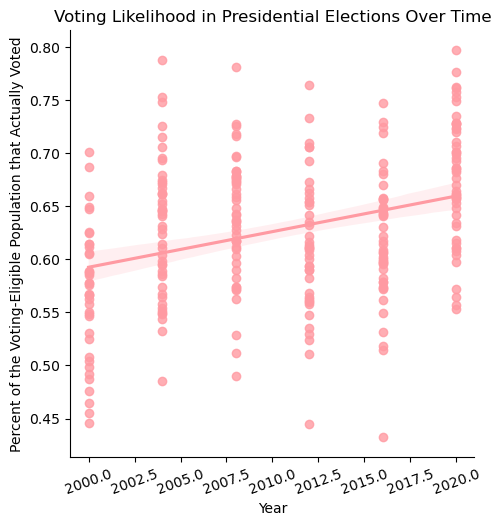

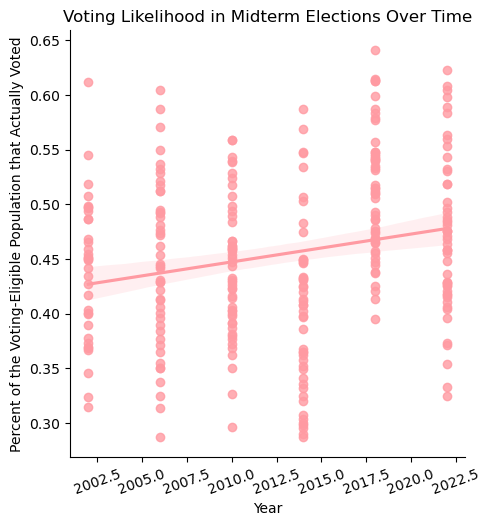

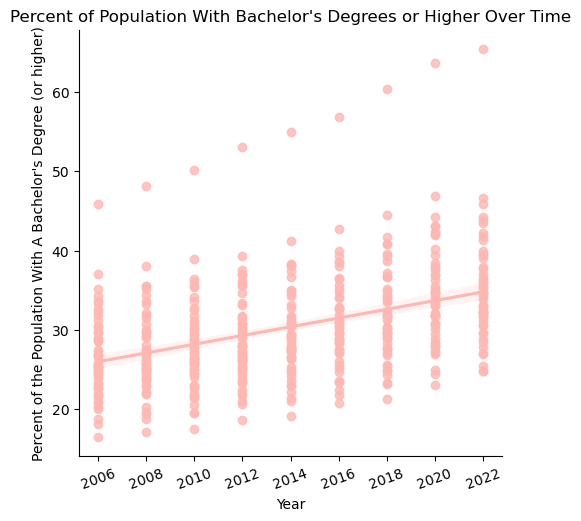

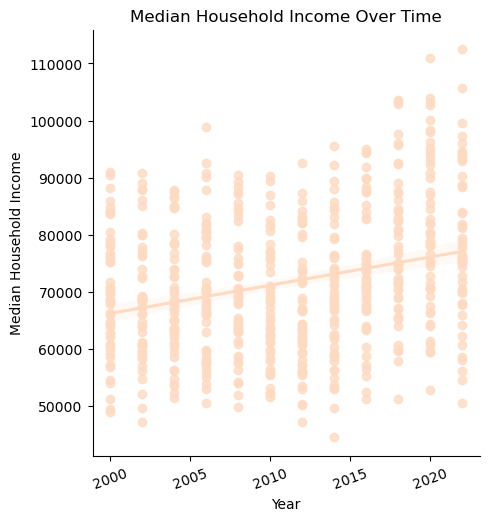

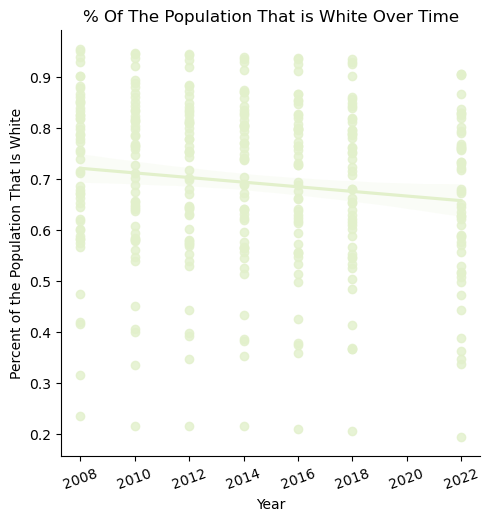

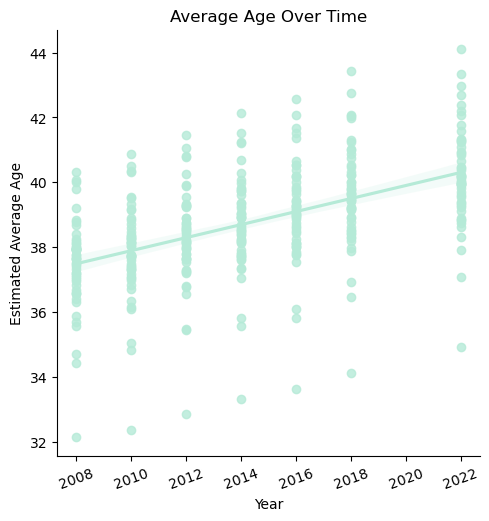

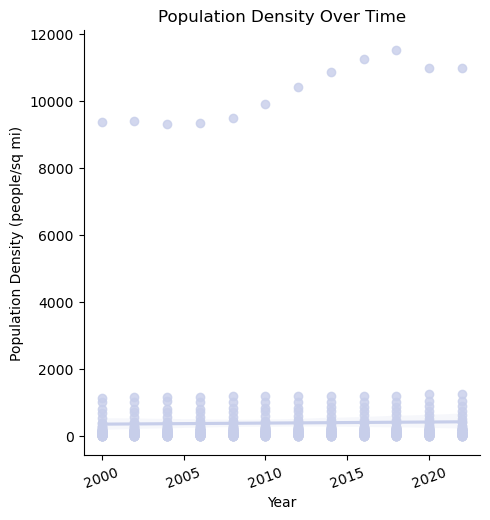

In [176]:
#split the data based on the election year type (renaming for simplicity)
plotting_data_presidential = election_demographics[election_demographics['Presidential'] == True]
plotting_data_midterm = election_demographics[election_demographics['Presidential'] == False]
plotting_data_total = election_demographics

#plot 1
plot = sns.lmplot(data=plotting_data_presidential, x='Year',y='PercentVotingEligibleVotes',scatter_kws={'color': '#FF9AA2'},line_kws={'color': '#FF9AA2'})
plt.xticks(rotation=20)
plt.xlabel('Year')
plt.ylabel('Percent of the Voting-Eligible Population that Actually Voted')
plt.title('Voting Likelihood in Presidential Elections Over Time')
plt.show()

#plot 2
plot = sns.lmplot(data=plotting_data_midterm, x='Year',y='PercentVotingEligibleVotes',scatter_kws={'color': '#FF9AA2'},line_kws={'color': '#FF9AA2'})
plt.xticks(rotation=20)
plt.xlabel('Year')
plt.ylabel('Percent of the Voting-Eligible Population that Actually Voted')
plt.title('Voting Likelihood in Midterm Elections Over Time')
plt.show()

#plot 3
plot = sns.lmplot(data=plotting_data_total, x='Year',y='PercentBachelors',scatter_kws={'color': '#FFB7B2'},line_kws={'color': '#FFB7B2'})
plt.xticks(rotation=20)
plt.xlabel('Year')
plt.ylabel('Percent of the Population With A Bachelor\'s Degree (or higher)')
plt.title('Percent of Population With Bachelor\'s Degrees or Higher Over Time')
plt.show()

#plot 4
plot = sns.lmplot(data=plotting_data_total, x='Year',y='Income',scatter_kws={'color': '#FFDAC1'},line_kws={'color': '#FFDAC1'})
plt.xticks(rotation=20)
plt.xlabel('Year')
plt.ylabel('Median Household Income')
plt.title('Median Household Income Over Time')
plt.show()

#plot 5
plot = sns.lmplot(data=plotting_data_total, x='Year',y='PercentWhite',scatter_kws={'color': '#E2F0CB'},line_kws={'color': '#E2F0CB'})
plt.xticks(rotation=20)
plt.xlabel('Year')
plt.ylabel('Percent of the Population That Is White')
plt.title('% Of The Population That is White Over Time')
plt.show()

#plot 6
plot = sns.lmplot(data=plotting_data_total, x='Year',y='AverageAge',scatter_kws={'color': '#B5EAD7'},line_kws={'color': '#B5EAD7'})
plt.xticks(rotation=20)
plt.xlabel('Year')
plt.ylabel('Estimated Average Age')
plt.title('Average Age Over Time')
plt.show()

#plot 7
plot = sns.lmplot(data=plotting_data_total, x='Year',y='PopulationDensity',scatter_kws={'color': '#C7CEEA'},line_kws={'color': '#C7CEEA'})
plt.xticks(rotation=20)
plt.xlabel('Year')
plt.ylabel('Population Density (people/sq mi)')
plt.title('Population Density Over Time')
plt.show()

From the above plots, we were able to discern that there are some very clear time-related trends regarding all of data, which is both a good and bad thing. It's good in the sense that we are likely to come across correlation between two different data points. However, since our correlation might be very high between multiple different variables, we have to watch out for collinearity when running regressions or similar kinds of models on our data. On a similar note, we must note that correlation and causation are two different things, so we have to distinguish between them in our findings.

This also helps to verify our data, since most of the findings mirror what we expect given our domain knowledge surrounding politics and social factors.

Finally, we're able to see some pretty clear outliers in our data (though not labeled - certainly can be later) which will be nice to know moving forward. Notably, the fact that D.C. is included as a state throws off the population density chart, for example.

From this point, we'll compare more than just time against a column. Here, our plots will incorporate two different columns to see if there exists a trend between them, and how that trend has or has not changed over time. Remember that in each of these plots, a single dot with a given color represents a state for a particular year. Therefore, looking at the slopes of the lines in the chart, we can quickly see if the correlation is positive or negative, and comparing the line positions, we can quickly see if that trend has changed.

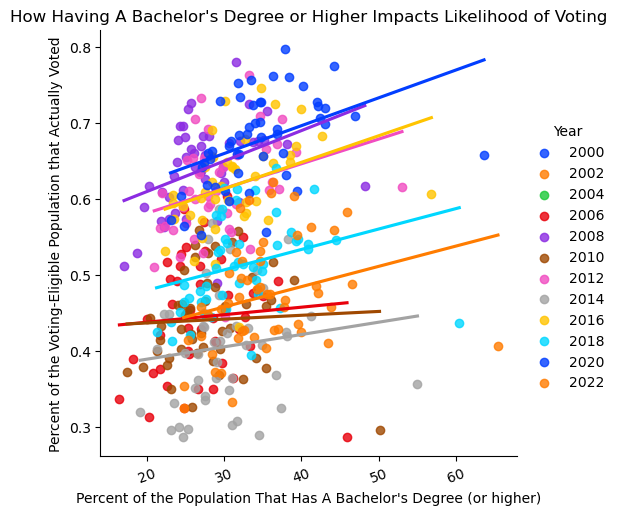

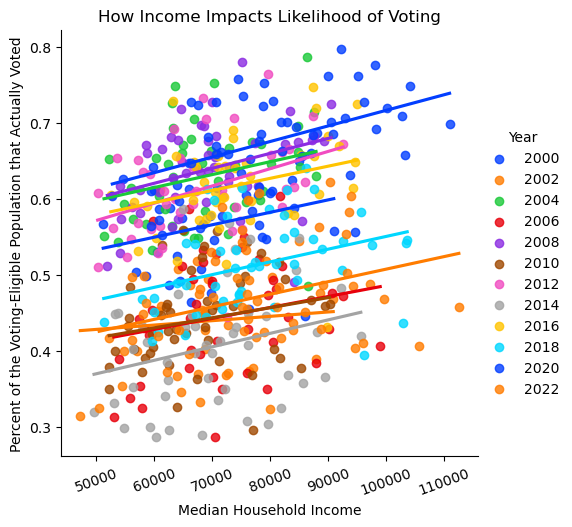

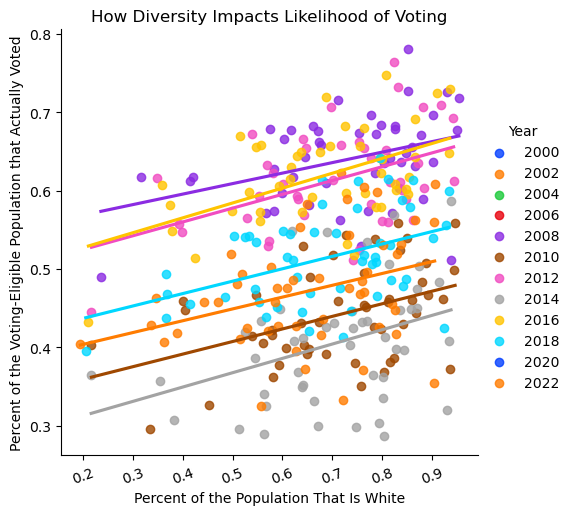

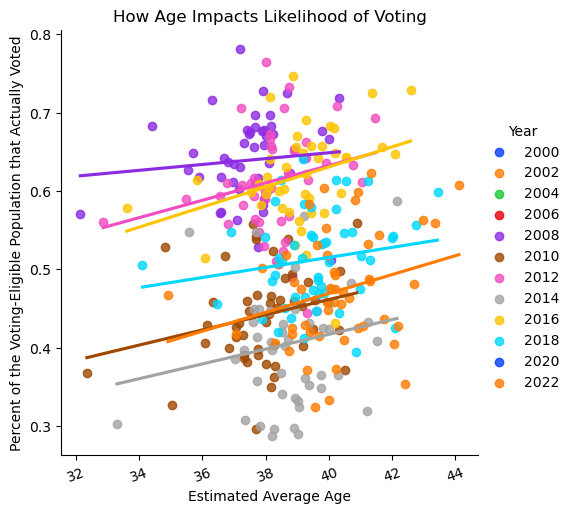

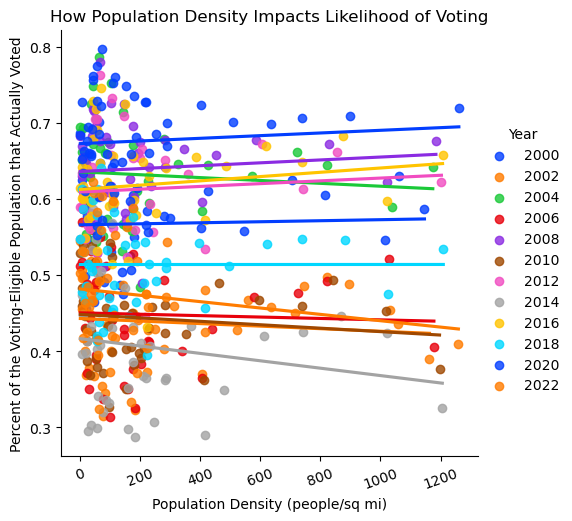

In [177]:
#plot 8
plot = sns.lmplot(data=plotting_data_total, x='PercentBachelors',y='PercentVotingEligibleVotes',hue='Year',palette="bright",ci=None)
plt.xticks(rotation=20)
plt.xlabel('Percent of the Population That Has A Bachelor\'s Degree (or higher)')
plt.ylabel('Percent of the Voting-Eligible Population that Actually Voted')
plt.title('How Having A Bachelor\'s Degree or Higher Impacts Likelihood of Voting')
plt.show()

#plot 9
plot = sns.lmplot(data=plotting_data_total, x='Income',y='PercentVotingEligibleVotes',hue='Year',palette="bright",ci=None)
plt.xticks(rotation=20)
plt.xlabel('Median Household Income')
plt.ylabel('Percent of the Voting-Eligible Population that Actually Voted')
plt.title('How Income Impacts Likelihood of Voting')
plt.show()

#plot 10
plot = sns.lmplot(data=plotting_data_total, x='PercentWhite',y='PercentVotingEligibleVotes',hue='Year',palette="bright",ci=None)
plt.xticks(rotation=20)
plt.xlabel('Percent of the Population That Is White')
plt.ylabel('Percent of the Voting-Eligible Population that Actually Voted')
plt.title('How Diversity Impacts Likelihood of Voting')
plt.show()

#plot 11
plot = sns.lmplot(data=plotting_data_total, x='AverageAge',y='PercentVotingEligibleVotes',hue='Year',palette="bright",ci=None)
plt.xticks(rotation=20)
plt.xlabel('Estimated Average Age')
plt.ylabel('Percent of the Voting-Eligible Population that Actually Voted')
plt.title('How Age Impacts Likelihood of Voting')
plt.show()

#removing DC since it is a very clear outlier for this data, and throws off the graph too much
plotting_data_total_no_dc = plotting_data_total[plotting_data_total['State'] != 'District of Columbia']
#plot 12
plot = sns.lmplot(data=plotting_data_total_no_dc, x='PopulationDensity',y='PercentVotingEligibleVotes',hue='Year',palette="bright",ci=None)
plt.xticks(rotation=20)
plt.xlabel('Population Density (people/sq mi)')
plt.ylabel('Percent of the Voting-Eligible Population that Actually Voted')
plt.title('How Population Density Impacts Likelihood of Voting')
plt.show()


Looking at our results, we can very clearly see some trends (and some non-trends). The fact that we're grouping by election year is especially important since you can somewhat see how different colored dots are grouped together and split from the others. This means that if we were to clump the data together under an 'all years' graph, though we still might see the same positive or negative correlation, the variance of the data around the correlation line would be much higher (making our conclusion weaker). 

This builds into the next idea which is how the years are actually split. Nearly all the graphs have visible differences between midterm elections and presidential elections (with more people voting in the latter). Seeing this result in these plots is a good indicator that we should continue to either split the data up by year or whether or not the election is a presidential one. 

It's also a good sign that the plots we're making follow our intuitions about how socio-economic factors can influence a person's ability and willingness to vote.

Finally, notice how population density has little to no (visible) effect on the voting percentage, so, after review, we've decided to remove that from our potential model inputs.

We'll now split the data by state, since that's a key element of our project. For now, we'll leave the data aggregated (instead of splitting by year), since we somewhat did that earlier, and it would make some of the plots unreadable. Finding an appropriate way to visualize findings by state is a problem we can tackle in the future. 

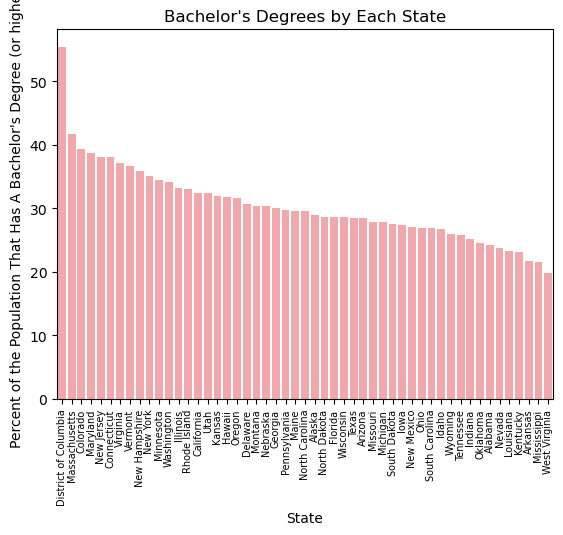

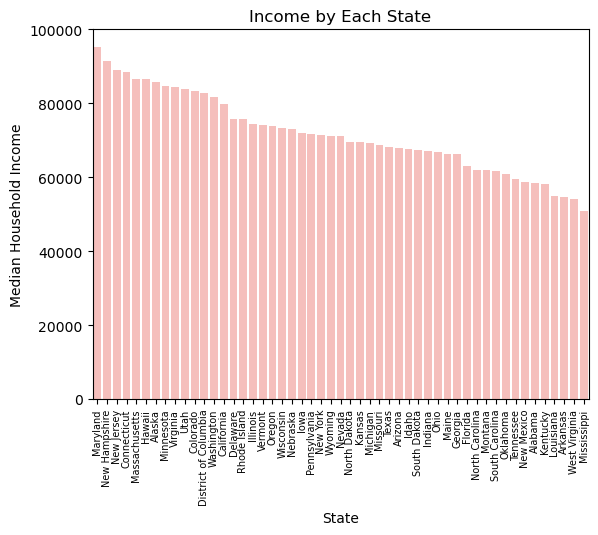

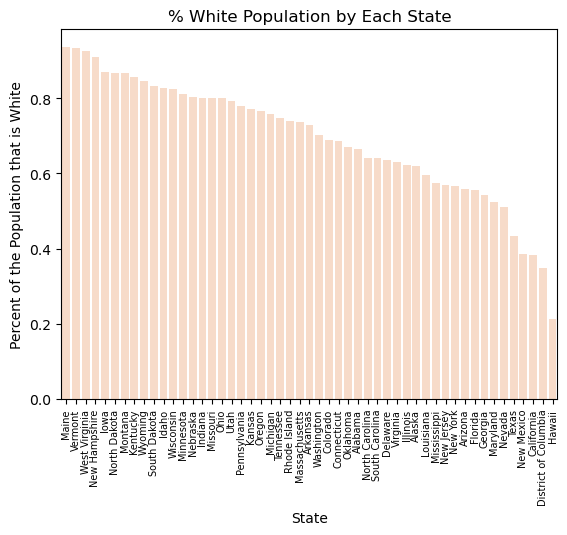

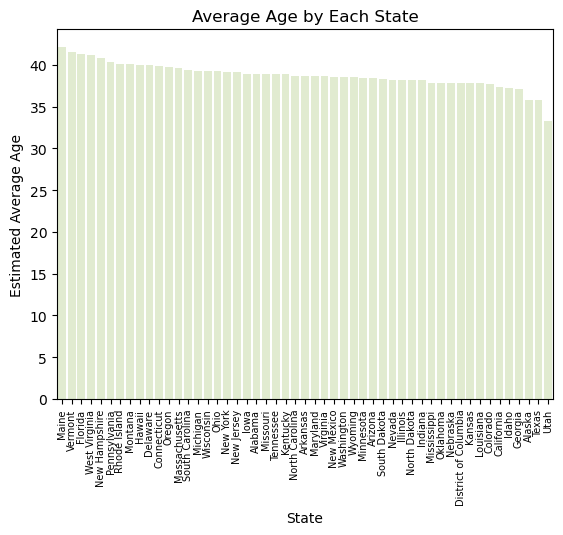

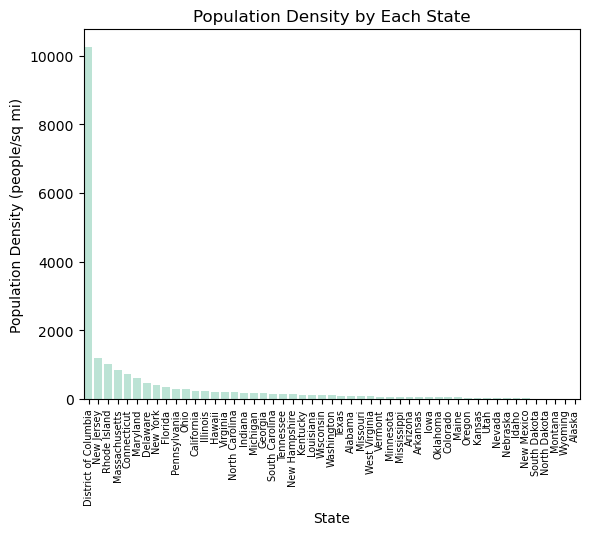

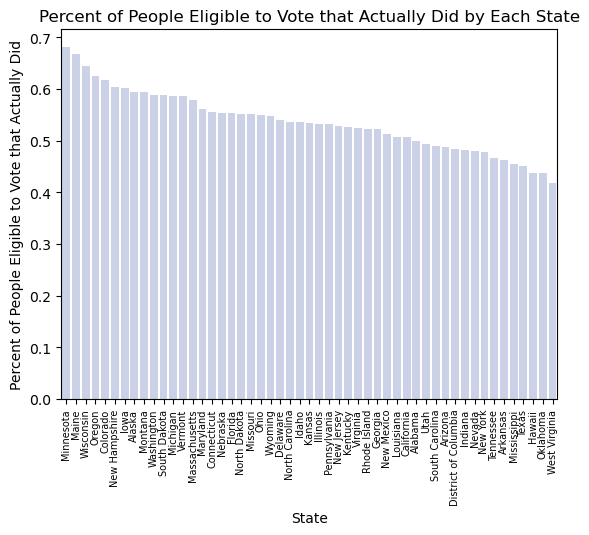

In [178]:
#group the data
grouped_state_data = election_demographics.groupby('State')['PercentBachelors'].mean().reset_index()
#plot 13
plot = sns.barplot(data=grouped_state_data, x='State',y='PercentBachelors', 
                   order=grouped_state_data.sort_values('PercentBachelors', ascending=False).State, color="#FF9AA2")
plt.xticks(rotation=90, size=7)
plt.xlabel('State')
plt.ylabel('Percent of the Population That Has A Bachelor\'s Degree (or higher)')
plt.title('Bachelor\'s Degrees by Each State')
plt.show()
#group the data
grouped_state_data = election_demographics.groupby('State')['Income'].mean().reset_index()
#plot 14
plot = sns.barplot(data=grouped_state_data, x='State',y='Income', 
                   order=grouped_state_data.sort_values('Income', ascending=False).State, color="#FFB7B2")
plt.xticks(rotation=90, size=7)
plt.xlabel('State')
plt.ylabel('Median Household Income')
plt.title('Income by Each State')
plt.show()
#group the data
grouped_state_data = election_demographics.groupby('State')['PercentWhite'].mean().reset_index()
#plot 15
plot = sns.barplot(data=grouped_state_data, x='State',y='PercentWhite', 
                   order=grouped_state_data.sort_values('PercentWhite', ascending=False).State, color="#FFDAC1")
plt.xticks(rotation=90, size=7)
plt.xlabel('State')
plt.ylabel('Percent of the Population that is White')
plt.title('% White Population by Each State')
plt.show()
#group the data
grouped_state_data = election_demographics.groupby('State')['AverageAge'].mean().reset_index()
#plot 16
plot = sns.barplot(data=grouped_state_data, x='State',y='AverageAge', 
                   order=grouped_state_data.sort_values('AverageAge', ascending=False).State, color="#E2F0CB")
plt.xticks(rotation=90, size=7)
plt.xlabel('State')
plt.ylabel('Estimated Average Age')
plt.title('Average Age by Each State')
plt.show()
#group the data
grouped_state_data = election_demographics.groupby('State')['PopulationDensity'].mean().reset_index()
#plot 17
plot = sns.barplot(data=grouped_state_data, x='State',y='PopulationDensity', 
                   order=grouped_state_data.sort_values('PopulationDensity', ascending=False).State, color="#B5EAD7")
plt.xticks(rotation=90, size=7)
plt.xlabel('State')
plt.ylabel('Population Density (people/sq mi)')
plt.title('Population Density by Each State')
plt.show()
#group the data
grouped_state_data = election_demographics.groupby('State')['PercentVotingEligibleVotes'].mean().reset_index()
#plot 18
plot = sns.barplot(data=grouped_state_data, x='State',y='PercentVotingEligibleVotes', 
                   order=grouped_state_data.sort_values('PercentVotingEligibleVotes', ascending=False).State, color="#C7CEEA")
plt.xticks(rotation=90, size=7)
plt.xlabel('State')
plt.ylabel('Percent of People Eligible to Vote that Actually Did')
plt.title('Percent of People Eligible to Vote that Actually Did by Each State')
plt.show()

These plots, though simple, are very useful for finding key outliers in our data. We notice that there is a very clear outlier in population density (DC). We also can take note of the fact that the average age of every state has very little change between states (as compared to the other plots). We can take this into account when we conduct further analysis by possible grouping the states together for that particular age - looking more at a national trend by year (which we know exists from the first set of plots), rather than trying to discern essentially non-existent differences in ages between states.

Next, we'll quickly plot a few correlation matrices to see if there's anything that sticks out that we might be able to use later.

In [175]:
corr_df_total = election_demographics[['PercentVotingEligibleVotes','PercentBachelors','Presidential',
                                 'Income','PercentWhite','AverageAge','PopulationDensity']].corr()

corr_df_presidential = plotting_data_presidential[['PercentVotingEligibleVotes','PercentBachelors',
                                 'Income','PercentWhite','AverageAge','PopulationDensity']].corr()

corr_df_midterm = plotting_data_midterm[['PercentVotingEligibleVotes','PercentBachelors',
                                 'Income','PercentWhite','AverageAge','PopulationDensity']].corr()

# corr_df_total
corr_df_presidential
# corr_df_midterm

,PercentVotingEligibleVotes,PercentBachelors,Income,PercentWhite,AverageAge,PopulationDensity
PercentVotingEligibleVotes,1.000000,0.404024,0.387698,0.460212,0.149271,-0.023422
PercentBachelors,0.404024,1.000000,0.790070,-0.249103,0.119512,0.599095
Income,0.387698,0.790070,1.000000,-0.123512,-0.032517,0.192874
PercentWhite,0.460212,-0.249103,-0.123512,1.000000,0.221903,-0.343538
AverageAge,0.149271,0.119512,-0.032517,0.221903,1.000000,-0.006777
PopulationDensity,-0.023422,0.599095,0.192874,-0.343538,-0.006777,1.000000


While the individual values seem somewhat promising for further analysis - we can try to get a correlation coefficient of 0.7 with our data - perhaps the most important discovery is how the correlation coefficients change between different matrices for different elections. The coefficients are significantly stronger for both only presidential elections and only midterm elections (as compared to all elections all together). While we predicted this might happen from our plots, to have the numbers that back it up is nice.

Also notice that there is a strong correlation between Income and PercentBachelors, which is something look out for when building our model (collinearity).

## Data Limitations

Ideally, our dataset would analyze trends and statistics by county, but we weren’t able to find data that specific. In the future, we would try to find more targeted statistics more accurately depicting the diverse demographics within each state.

We’re missing data regarding turnout percentage, 5 years for age distribution and diversity, as well as 3 years for Bachelor's degree percentages. We had to use NaNs for values, which could make it harder for us to analyze key trends in specific years.

There were some factors that would be good to include which either aren’t quantifiable or that we couldn’t find as much data for. This includes voter registration laws, marital status, and voting breakdown by age group as well as state and year.

Each of these limitations make it somewhat harder to draw more actionable or meaningful insights from the analyzed data. Analyzing on a statewide level, rather than a more targeted focus, provides more of a broader overview of voting trends rather than specific analysis based on urban versus rural areas. For example, California is a populous state, but most of the population is concentrated in the Bay Area and Southern California while Northern California is almost entirely rural. Looking at California as a whole, we cannot make very specific comparisons. However, we can still compare trends between densely populated and less densely populated regions. Because of this generalization rather than specificity, we decided to include many more factors to take a targeted approach. 

As for dropping missing values, we missed values such as racial diversity for some years. This would make it harder to navigate trends and track the impact of race on turnout from 2000-2008, which is an important factor to look at. On the other hand, this gave us important experience with data cleaning as we had to figure out which rows or column values to drop and how to handle NaN values. Lastly, there were some features that we weren’t able to find enough data for which would be important to include in a comprehensive analysis of voting patterns, such as voter registration laws and voting breakdown by age group. We tried to account for these factors by, for example, looking at the average age by state from 2000-2022, which was available. While this isn’t as specific of a picture, we were somewhat able to account for considering age’s affect on voting. In the future, we hope to find comprehensive datasets including some of the values we were missing and find ways to quantify other factors like voting laws.

Additionally, it was difficult to find a comprehensive and complete dataset on the swing states for each election, which would be nice to have when seeing if voters in those swing states vote at higher rates than others. However, the limit to this data is the fact that it would only be applicable to presidential elections, so only 5 of the elections, making it debatable whether it's worth including.

# Questions for Reviewers


 1. NaNs are by far our biggest concern with our dataset, since they limit the extent to which we can conduct analysis (and thus the quality). How do you suggest we approach this problem? Should we try to fill them in manually?
 2. Is this dataset pretty comprehensive or should we try including any other variables into our analysis?
 3. What’s the best way to compare trends in voter turnout rates over time between different states without creating a cluttered visual depiction? This was the most difficult part of our exploratory analysis.
 4. Do you think it would be worth it to include data about swing states, given its limitations (see the last paragraph from above)? If so, where should we look to find an accurate list of swing states (since classifying something as a swing state is fairly subjective, at least compared to the rest of the data in our dataframe)?

 Thanks! :)
